# Extracting Information from Images - Wikimania Tutorial :)
## This notebook contains a set of quick scripts to extract interpretable image features. 
#### Features include color distribution, faces, and objects.

It is *almost* plug-and-play, you will just have to create a couple of API keys, install a few libraries, and you are done. Just take this code and put it in a loop over all your images to extract features for your whole dataset.


##### Requirements
* OPENCV: pip install opencv-python
* Tensorflow: pip install tensorflow==1.14.0
* Google Vision API: pip install google-cloud-vision
* Numpy/Math/Matplotlib (probably you have them already)
* All files/scripts in this folder
##### API keys
* Face++: https://console.faceplusplus.com It's free ;D
* Google Vision API: create credentials from https://console.cloud.google.com/apis/credentials->create credentials-->service account keys, then save the resulting file into credentials/vision_api.json



In [1]:

'''
importing the libraries
'''
#general
import os
import math
import json
from matplotlib import pyplot as plt

#for matrix computations and plotting
import cv2
import numpy as np

#import libraries for google Vision API
from google.cloud import vision

#importing scripts for Face++
from facepp import API
from facepp import File

#you will have to have tensorflow installed to run the code in the file below. 
import classify_image_tensorflow as tfclassify

'''
initializing context
'''
#replace this with your API keys for Face++
API_KEY = '2Gi7uH01b78GNQS5cC0qIr2Z84ehG0PB'
API_SECRET = 'SnIQKImmpZmOmuCkGcjcqvaRwgg8M1mx'
api = API(API_KEY, API_SECRET)

#this is the environment variable with the credentials for Google Vision API
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="credentials/vision_api.json"


In [2]:
'''
A couple of useful plotting functions - let's skip the details, this is just for us to visulize the images we are dealing with
'''

def plot_image(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #transforming to rgb for visualization
    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)
    plt.imshow(img_rgb)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def plot_hsv(h,s,v):
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18.5, 4)

    fig.suptitle('RGB IMAGE')
    ax1.imshow(h,cmap="hsv")
    ax1.set_title('Hue')
    ax2.imshow(s,cmap="gray")
    ax2.set_title('Saturation')
    ax3.imshow(v,cmap="gray")
    ax3.set_title('Brightness')
    plt.show()

## Extracting Colors
###  Goal: extract a color distribution in a human-readable format
Starting point: 
OPENCV, the simplest library for image analysis. By default, OpenCV reads the image in the RGB space.
![Image](https://img1.freepng.es/20180625/gpx/kisspng-rgb-color-space-rgb-color-model-light-5b30931fa1fb14.2738796215299100476635.jpg)

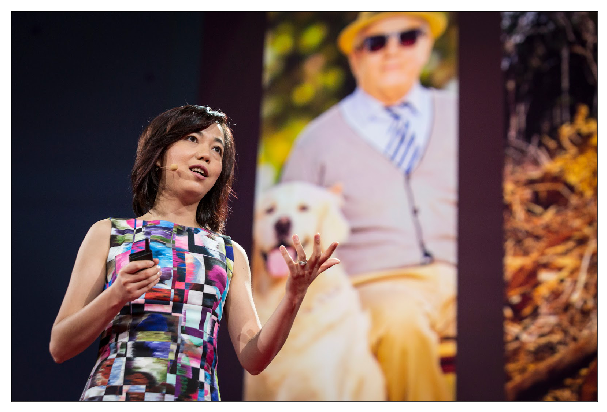

(1067, 1600, 3)

In [3]:
'''
here we read and plot an image, and try to understand what the image is made of
'''
img = cv2.imread('images/Fei-Fei.jpg')
plot_image(img)
img.shape

In [4]:
'''
the image is 3 dimensional matrix, the first 2 dimensions are width and height, the third is the depth, or color channel. 
For color images, the depth is 3, Red, Green, and Blue.
'''
img[:4,:4,:].T

array([[[14, 14, 14, 14],
        [14, 14, 14, 14],
        [14, 14, 14, 14],
        [14, 14, 14, 14]],

       [[ 6,  6,  6,  6],
        [ 6,  6,  6,  6],
        [ 6,  6,  6,  6],
        [ 6,  6,  6,  6]],

       [[ 6,  6,  6,  6],
        [ 6,  6,  6,  6],
        [ 6,  6,  6,  6],
        [ 6,  6,  6,  6]]], dtype=uint8)

Sampling RGB histograms is not very effective if we want to get interpretable features.
__The HSV Space gives a more interpretable representation.__
<img align="left" width="300" height="300" src="https://www.mathworks.com/help/images/hsvcone.gif">
<img align="center" width="300" height="300" src="http://www.texample.net/media/tikz/examples/PNG/hsv-shading.png">
The Hue value represent the pure color tone, it's a value from 0 to 360 (180 in OpenCV) where 0 is red, 30 is orange, etc.


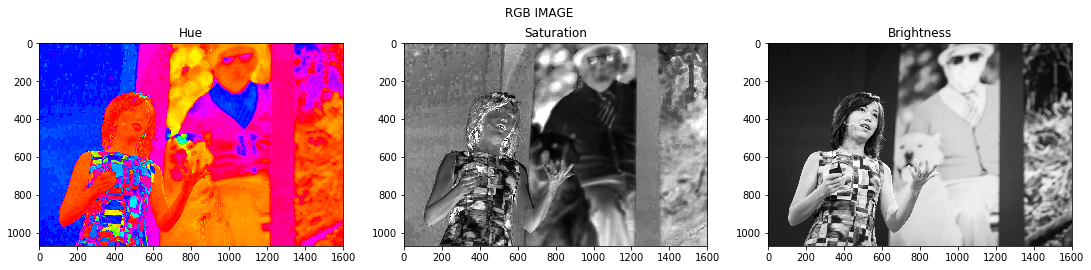

In [5]:
'''
let's have a look at what the hsv space looks like
'''
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert irgbto hsv
h,s,v = cv2.split(hsv_img) #isolating the 3 channels
plot_hsv(h,s,v)

In [6]:
'''
What are the dominant colors of an image? 
Just count the number of pixels in the hue space belonging to each color.
'''
def extract_color_distribution(h):
    #creating a dictionary of 12 colors sampled from the hue space
    color_names=['Red','Orange','Yellow','Yellow-Green','Green','Aqua',
                 'Cyan','Azure','Blue','Violet','Magenta,','Rose'] 
    #quantize each pixel from a value in the range (180) to a value between 0 and 11
    h_quant=np.floor(np.divide(h,15)) 
    #compute distribution over these 12 values
    color_values=np.histogram(h_quant,12)[0]
    color_values=color_values/float(h.shape[0]*h.shape[1])
    #assign a label to each bin of the color distribution
    color_dict={color_names[i]:color_values[i] for i in range(len(color_values))}
    return color_dict

In [7]:
'''
Extracting color dictionary from the hue channel of the original image
'''
color_dict=extract_color_distribution(h)
color_dict

{'Aqua': 0.0025685332708528584,
 'Azure': 0.13675082005623243,
 'Blue': 0.10930822399250234,
 'Cyan': 0.010995196813495783,
 'Green': 0.0011141049671977508,
 'Magenta,': 0.1343609418931584,
 'Orange': 0.14916119962511715,
 'Red': 0.27282450796626057,
 'Rose': 0.13892221180880976,
 'Violet': 0.03446286316776007,
 'Yellow': 0.007589034676663543,
 'Yellow-Green': 0.0019423617619493908}

##  Computing Sharpness
#### A good proxy for Image Quality
Sharpness= definition of image edges, clarity of the shapes


<img align="left" width="600" height="300" src="https://improvephotography.com/wp-content/uploads/2014/07/sharpness-eyes-example.jpg">


In [8]:
'''
computing image sharpness as the magnitude of the gradient computed through Sobel edge detectors
'''
def compute_sharpness(img):
    img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dx = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
    dy = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=5)
    return dx,dy

def plot_sharpness(img,dx,dy):
    plt.clf
    img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dx = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=31)
    dy = cv2.Sobel(img_gray,cv2.CV_64F,0,1,ksize=31)
    fig, (ax1, ax2,ax3) = plt.subplots(1,3)
    fig.set_size_inches(20, 5)
    fig.suptitle('Edge Detection with Sobel Filter')
    ax1.imshow(img_rgb)
    ax1.set_title('Original')
    ax2.imshow(dx,cmap="gray")
    ax2.set_title('Vertical edges')
    ax3.imshow(dy,cmap="gray")
    ax3.set_title("Horizontal edges")
    plt.show()

def sharpness_feature(dx,dy):
    gradient_magnitude=cv2.magnitude(dx,dy)
    return np.sum(gradient_magnitude)/float(dx.shape[0]*dx.shape[1])

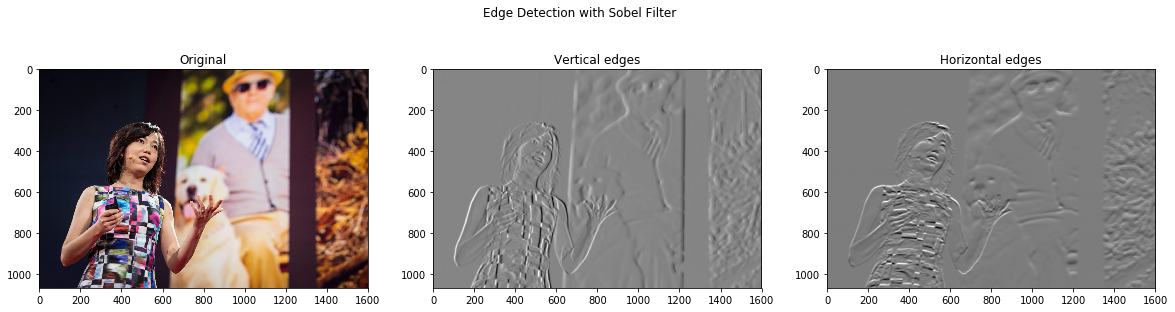

346.67548125453266

In [9]:
#computing sharpness on Fei Fei's image
dx,dy=compute_sharpness(img)
plot_sharpness(img,dx,dy)
sharpness=sharpness_feature(dx,dy)
sharpness

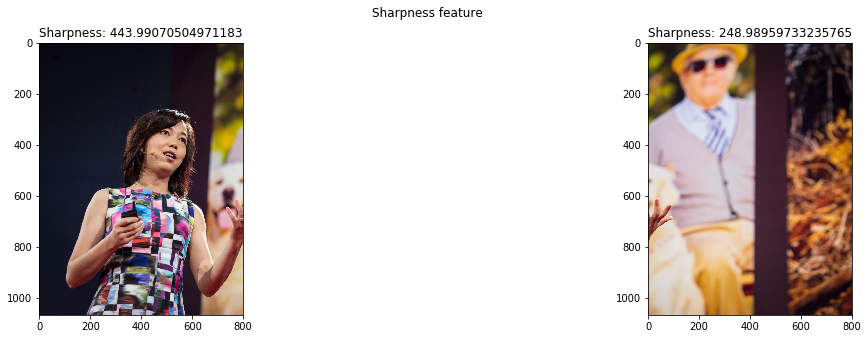

In [10]:
'''
Testing that the feature works by looking at the two halves of the image
'''
left_half=img[:,:int(img.shape[1]/float(2)),:]
right_half=img[:,int(img.shape[1]/float(2)):,:]

dxl,dyl=compute_sharpness(left_half)
dxr,dyr=compute_sharpness(right_half)
plt.clf()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(20, 5)
fig.suptitle('Sharpness feature')
ax1.imshow(cv2.cvtColor(left_half, cv2.COLOR_BGR2RGB))
ax1.set_title('Sharpness: '+str(sharpness_feature(dxl,dyl)))
ax2.imshow(cv2.cvtColor(right_half, cv2.COLOR_BGR2RGB))
ax2.set_title('Sharpness: '+str(sharpness_feature(dxr,dyr)))

plt.show()


## Analyzing Faces
#### Face detection, gender, age, expression classification, and face landmark localization
There are a number of open source solutions available, based on tensroflow. Here we look at an existing API, Face++, that has been shown to be very accurate to detect certain properties.
Due to the training data, some of the models behind these APIs are more or less accurate depending on the demographics of the faces to be characterized.
![Image](images/gendershades.png)
Tip: when you do large-scale analysis, always double check face model biases with the gendershades dataset: http://gendershades.org


In [11]:
'''
Calling Face++ Api. All files and libraries to generate this call as in this repo. 
Just make sure you import them, and nothing to worry about. 
The face detection function also allows for ethnicity detection. Skipping here for inclusiveness purpose.
Face++ also has more functions beyond classifying faces. 
Just check the request URL (for example: https://console.faceplusplus.com/documents/10880589) 
and change it in the detect funciton of the faceapp.py file.
'''
facedata=api.detect(image_file =File('images/Fei-Fei.jpg'),return_attributes='gender,age,smiling,eyestatus');
#this function returns a dictionary. The "faces" field  is a list of X elements where X is the number of faces detected
len(facedata["faces"])

2

In [12]:
#info about the first face detected
facedata["faces"][0]

{u'attributes': {u'age': {u'value': 56},
  u'eyestatus': {u'left_eye_status': {u'dark_glasses': 95.182,
    u'no_glass_eye_close': 4.329,
    u'no_glass_eye_open': 0.445,
    u'normal_glass_eye_close': 0.012,
    u'normal_glass_eye_open': 0.017,
    u'occlusion': 0.015},
   u'right_eye_status': {u'dark_glasses': 98.583,
    u'no_glass_eye_close': 0.637,
    u'no_glass_eye_open': 0.771,
    u'normal_glass_eye_close': 0.0,
    u'normal_glass_eye_open': 0.001,
    u'occlusion': 0.007}},
  u'gender': {u'value': u'Male'},
  u'glass': {u'value': u'Dark'},
  u'smile': {u'threshold': 50.0, u'value': 11.65}},
 u'face_rectangle': {u'height': 201, u'left': 956, u'top': 38, u'width': 201},
 u'face_token': u'532146f6aad165f2fefdf77a717978c2'}

In [13]:
#info about the second face detected
facedata["faces"][1]

{u'attributes': {u'age': {u'value': 27},
  u'eyestatus': {u'left_eye_status': {u'dark_glasses': 0.0,
    u'no_glass_eye_close': 0.0,
    u'no_glass_eye_open': 99.999,
    u'normal_glass_eye_close': 0.0,
    u'normal_glass_eye_open': 0.001,
    u'occlusion': 0.0},
   u'right_eye_status': {u'dark_glasses': 0.0,
    u'no_glass_eye_close': 0.0,
    u'no_glass_eye_open': 100.0,
    u'normal_glass_eye_close': 0.0,
    u'normal_glass_eye_open': 0.0,
    u'occlusion': 0.0}},
  u'gender': {u'value': u'Female'},
  u'glass': {u'value': u'None'},
  u'smile': {u'threshold': 50.0, u'value': 84.957}},
 u'face_rectangle': {u'height': 172, u'left': 410, u'top': 328, u'width': 172},
 u'face_token': u'4daf91deef8ab8a53363f3a9f58b1437'}

## Detecting Objects
#### Everything beyond faces
There are a two ways of doing this. The open source way is to use tensorflow-based models trained on Imagenet: http://www.image-net.org/. 
Imagenet is the largest image dataset available, the visual version of imagenet, it spans thousands of categories. Generally it is used by CV researchers as a benchmark for image classifiers. The most popular versions of imagenet-based classifiers are able to distinguish between 1k objects.
The complete list of objects is here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
This script uses the Inception-v3 Architecture
![Image](https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png)
Tip: this code is using an older version of the inception model, to download the latest one, change the url in the classify_image_tensorflow.py script to: http://download.tensorflow.org/models/image/imagenet/inception-latest.tgz

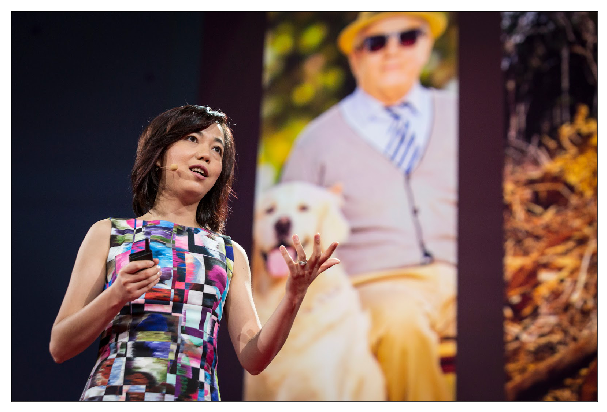

kuvasz (score = 0.45163)
Bedlington terrier (score = 0.34581)
dalmatian, coach dog, carriage dog (score = 0.03303)
Great Pyrenees (score = 0.02510)
pajama, pyjama, pj's, jammies (score = 0.02300)


In [14]:
'''Just one line of code. This returns the top-5 predictions, i.e. the 5 output neurons and their activation score,
but let's look at the objects for which the model is most confident about.'''
plot_image(img)
tfclassify.classify('images/Fei-Fei.jpg')

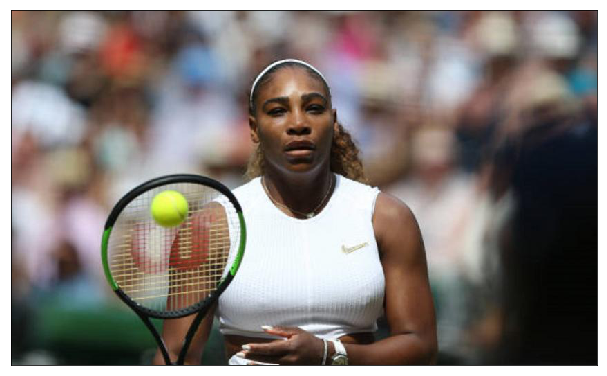

racket, racquet (score = 0.69097)
tennis ball (score = 0.30281)
electric fan, blower (score = 0.00005)
hair spray (score = 0.00005)
strainer (score = 0.00004)


In [15]:
'''Let's try with another image'''
img_serena=cv2.imread('images/serena.jpg')
plot_image(img_serena)
tfclassify.classify('images/serena.jpg')

## Detecting absolutely everyting
#### Using Google Vision API
You have a limit of 1k requests with the free account. But Google Vision API detects face characteristics, object, scenes, and web entitites.
Similar to other models, the training data plays an important role. Vision API somehow clssifies in different ways images about the same subject coming from different places in the world.
![Image](images/bias.png)
Improvements will come thanks to the recent efforts in the community including the "Inclusive Image Challenge" https://www.kaggle.com/c/inclusive-images-challenge

In [17]:
'''
Just prepare the request for the API, using your image path. 
You can also use image urls if the images you want to classify are in the web.
Then run the annotate_image function.
'''
req = {
    "image": {"source": {'filename': 'images/serena.jpg'}}}

client = vision.ImageAnnotatorClient()
response = client.annotate_image(req)

#let's look at the coolest part: the web entities detected
response.web_detection.web_entities

[entity_id: "/m/015z4j"
score: 1.34624993801
description: "Serena Williams"
, entity_id: "/m/0mmmt"
score: 0.916350007057
description: "Wimbledon"
, entity_id: "/m/07bs0"
score: 0.73869997263
description: "Tennis"
, entity_id: "/m/0l6c9"
score: 0.670949995518
description: "The US Open (Tennis)"
, entity_id: "/m/0g94dh"
score: 0.541949987411
description: "Battle of the Sexes"
, entity_id: "/m/01c2c1"
score: 0.489199995995
description: "Grand Slam"
, entity_id: "/m/0fvb2"
score: 0.390300005674
description: "Women\'s Tennis Association"
, entity_id: "/m/06gqc5"
score: 0.287900000811
description: "Point"
, entity_id: "/m/0svt5"
score: 0.0901050046086
description: "Billie Jean King"
, entity_id: "/m/03b7gw"
score: 0.0670650005341
description: "Maria Sharapova"
]

In [18]:
response.label_annotations

[mid: "/m/07bs0"
description: "Tennis"
score: 0.989280641079
topicality: 0.989280641079
, mid: "/m/02xhr73"
description: "Tennis player"
score: 0.977313280106
topicality: 0.977313280106
, mid: "/m/0h8my_4"
description: "Tennis racket"
score: 0.969019591808
topicality: 0.969019591808
, mid: "/m/0dv9c"
description: "Racket"
score: 0.954382121563
topicality: 0.954382121563
, mid: "/m/01qhp_"
description: "Racquet sport"
score: 0.900545060635
topicality: 0.900545060635
, mid: "/m/07gcy"
description: "Tennis court"
score: 0.833667159081
topicality: 0.833667159081
, mid: "/m/0h8mj3b"
description: "Tennis racket accessory"
score: 0.819312274456
topicality: 0.819312274456
, mid: "/m/0b4_rz"
description: "Championship"
score: 0.817014038563
topicality: 0.817014038563
, mid: "/m/04stdlw"
description: "Competition event"
score: 0.786443293095
topicality: 0.786443293095
, mid: "/m/06ntj"
description: "Sports"
score: 0.776928961277
topicality: 0.776928961277
]

In [19]:
response.face_annotations[0]

bounding_poly {
  vertices {
    x: 322
    y: 60
  }
  vertices {
    x: 506
    y: 60
  }
  vertices {
    x: 506
    y: 274
  }
  vertices {
    x: 322
    y: 274
  }
}
fd_bounding_poly {
  vertices {
    x: 349
    y: 103
  }
  vertices {
    x: 474
    y: 103
  }
  vertices {
    x: 474
    y: 228
  }
  vertices {
    x: 349
    y: 228
  }
}
landmarks {
  type: LEFT_EYE
  position {
    x: 386.928253174
    y: 147.273529053
    z: -0.00111627939623
  }
}
landmarks {
  type: RIGHT_EYE
  position {
    x: 440.007324219
    y: 143.474502563
    z: 2.19757866859
  }
}
landmarks {
  type: LEFT_OF_LEFT_EYEBROW
  position {
    x: 365.130950928
    y: 139.158279419
    z: 7.16005086899
  }
}
landmarks {
  type: RIGHT_OF_LEFT_EYEBROW
  position {
    x: 399.935760498
    y: 131.831970215
    z: -7.15742969513
  }
}
landmarks {
  type: LEFT_OF_RIGHT_EYEBROW
  position {
    x: 424.424133301
    y: 129.190139771
    z: -6.01082229614
  }
}
landmarks {
  type: RIGHT_OF_RIGHT_EYEBROW
  positi

# The End!